# 神经网络-自动训练

让它能够自学习起来，做一个可以被训练，能够拟合数据的模型出来。 这里就需要了解一点反向传播的概念了

### 模型前向预测

神经网络能够预测物体，是因为他可以通过一个正向的信息传递，得到输入信息（比如猫的图片）加工后的一个结论（这张图片是猫）。

In [135]:
import numpy as np
import matplotlib.pyplot as plt

def draw_scatter(x, y):
    plt.scatter(x.ravel(), y.ravel())
    plt.show()

def draw_line(x, y):
    idx = np.argsort(x.ravel())
    plt.plot(x.ravel()[idx], y.ravel()[idx])
    plt.show()

# 在 Jupyter Notebook 中，如果你连续调用 draw_line 和 draw_scatter，它们会在不同的图中分别显示，因为 plt.show() 在每个函数中会触发一次图像的渲染。

def draw_combined(x, y_scatter, y_line):
    # 绘制散点图
    plt.scatter(x.ravel(), y_scatter.ravel(), color='blue', label='Scatter')
    
    # 绘制直线
    idx = np.argsort(x.ravel())
    plt.plot(x.ravel()[idx], y_line.ravel()[idx], color='red', label='Line')
    
    # 添加图例
    plt.legend()
    
    # 显示图形
    plt.show()

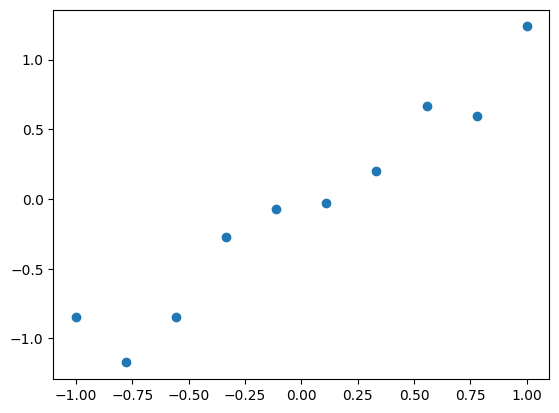

In [136]:
import numpy as np

# 数据
x = np.linspace(-1, 1, 10)[:, None]     # shape [10, 1]
y = np.random.normal(loc=0, scale=0.2, size=[10, 1]) + x   # shape [10, 1]

draw_scatter(x, y)

第一层出来后的 shape: (10, 3)
第二层出来后的 shape: (10, 1)
output: [[0.08492281]
 [0.09626316]
 [0.10760351]
 [0.11894386]
 [0.13028422]
 [0.14162457]
 [0.15296492]
 [0.16430527]
 [0.17564562]
 [0.18698597]]


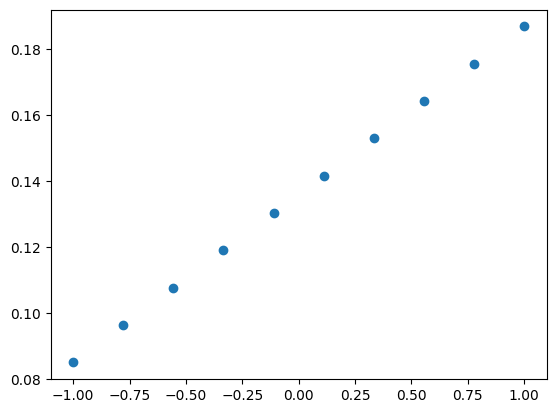

In [137]:
def layer(in_dim, out_dim):
    weights = np.random.normal(loc=0, scale=0.1, size=[in_dim, out_dim])
    bias = np.full([1, out_dim], 0.1)
    return {"w": weights, "b": bias}

# 模型
l1 = layer(1, 3)
l2 = layer(3, 1)

# 计算
o = x.dot(l1["w"]) + l1["b"]
print("第一层出来后的 shape:", o.shape)

o = o.dot(l2["w"]) + l2["b"]
print("第二层出来后的 shape:", o.shape)

print("output:", o)
draw_scatter(x, o)


但是很明显，对比两张图片，你会发现预测是 y 坐标存在明显的量级上的差距。 而我们今天要讲的，是如何让模型能够学习出来数据背后的规律，让它能够精准地预测数据

### 简单介绍反向传播

神经网络能够做前向的信息加工和预测，但是并不是一开始就能预测得很准的。模型得通过不断学习，不断修正自己的网络参数，才能慢慢变得精准。

我们通过什么样的方法和原则来做网络参数的修正？使之下次做前向预测的时候更准确？

简单来说，我们就是要找到每一个神经层的导数，用导数求梯度，用梯度来更新网络参数

In [138]:
def backprop(dz, layer, layer_in):
    gw = layer_in.T.dot(dz)
    gb = np.sum(dz, axis=0, keepdims=True)
    new_dz = dz.dot(layer["w"].T)
    layer["w"] += learning_rate * gw
    layer["b"] += learning_rate * gb
    return new_dz

#它的目标是计算每一层神经层的更新幅度，并按照学习率来更新网络参数，让网络对数据拟合得越来越好。

### 用 Numpy 来做神经网络的更新的步骤：

1. 准备好数据，搭建好模型

2. 开始训练循环

3. 前向预测，x 通过每一层计算得到 o2

4. 计算误差

5. 反向传播，更新网络


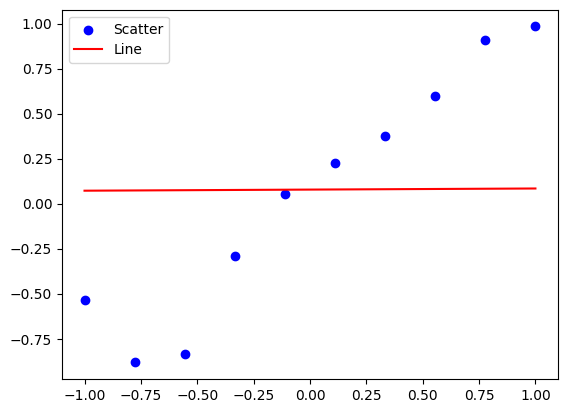

In [139]:
# 数据
x = np.linspace(-1, 1, 10)[:, None]     # shape [10, 1]
y = np.random.normal(loc=0, scale=0.2, size=[10, 1]) + x   # shape [10, 1]

# 搭建模型
l1 = layer(1, 3)
l2 = layer(3, 1)

def predict(x):
    o1 = x.dot(l1["w"]) + l1["b"]
    o2 = o1.dot(l2["w"]) + l2["b"]
    return [o1, o2]


draw_combined(x, y, predict(x)[-1])

0.4117890212036873
0.35080102369861227
0.2073917105341498
0.06540993036779642
0.03481503353891632


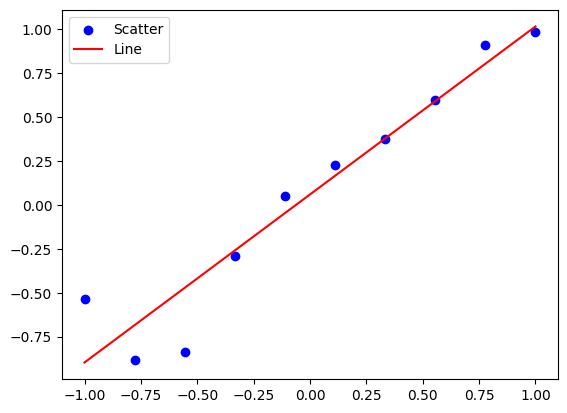

In [140]:
# 训练 50 次
learning_rate = 0.01
for i in range(50):
    # 前向预测
    o1, o2 = predict(x)
    
    # 误差计算
    if i % 10 == 0:
        average_cost = np.mean(np.square(o2 - y))
        print(average_cost)

    # 反向传播，梯度更新
    dz2 = -2 * (o2 - y)  # 输出误差 (o2 - y)**2 的导数
    dz1 = backprop(dz2, l2, o1)
    _ = backprop(dz1, l1, x)

# 画一个训练后的图，对比上文中有数值问题的线
draw_combined(x, y, predict(x)[-1])

### 加入激活函数

这个激活函数也同样是要考虑到反向传播中的。 和上面一样，我下面的功能是用来计算激活函数的梯度的，你可以当成工具直接来用，不一定要搞清楚其中的原理。

In [141]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):     # 导数
    return np.where(x > 0, np.ones_like(x), np.zeros_like(x))

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):     # 导数
    return 1 - np.square(np.tanh(x))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):  # 导数
    o = sigmoid(x)
    return o * (1 - o)

上面一个环节我们训练的是一个相对简单的线性数据，这次来一个非线性，比较复杂的。

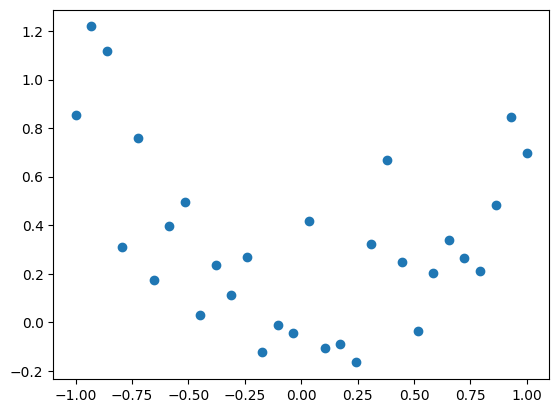

In [142]:
x = np.linspace(-1, 1, 30)[:, None]     # shape [30, 1]
y = np.random.normal(loc=0, scale=0.2, size=[30, 1]) + x**2   # shape [30, 1]

draw_scatter(x, y)

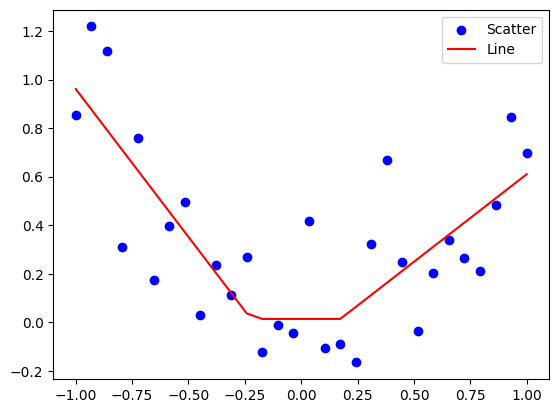

In [143]:
def predict(x):
    o1 = x.dot(l1["w"]) + l1["b"]
    a1 = relu(o1)   # 这里我添加了一个激活函数
    o2 = a1.dot(l2["w"]) + l2["b"]
    return [o1, a1, o2]

# 训练 300 次
learning_rate = 0.01
for i in range(300):
    # 前向预测
    o1, a1, o2 = predict(x)
    
    # 误差计算
    if i % 10 == 0:
        average_cost = np.mean(np.square(o2 - y))
        # print(average_cost)

    # 反向传播，梯度更新
    dz2 = -2 * (o2 - y)  # 输出误差 (o2 - y)**2 的导数
    dz1 = backprop(dz2, l2, a1)
    dz1 *= relu_derivative(o1)  # 这里要添加对应激活函数的反向传播
    _ = backprop(dz1, l1, x)

draw_combined(x, y, predict(x)[-1])